# MA 544 Final Project
## Clustering Movie Recomendations

In [21]:
### Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from IPython.display import display, HTML
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans

%matplotlib inline
plt.style.use('fivethirtyeight')

In [22]:
### Functions
def isolate_genre_ratings(df_ratings, df_movies, genre_list, col_names):
    '''
    Finds each users average rating for a specific genre

    Parameters
    ----------
    df_ratings : pandas.core.frame.DataFrame
        data frame of user ratings.
    df_movies : pandas.core.frame.DataFrame
        data frame for movies.
    genre_list : list
        list of genres to group by.
    col_names : list
        column names of the new average data frame.

    Returns
    -------
    df_genre_rating : pandas.core.frame.DataFrame
        users' average rating for each cateogry.

    '''
    df_genre_rating = pd.DataFrame()
    
    for genre in genre_list:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        df_genre_rating = pd.concat([df_genre_rating, avg_genre_votes_per_user], axis=1)
        
    df_genre_rating.columns = col_names
    return df_genre_rating


def draw_scatterplot(x_data, x_label, y_data, y_label):
    '''
    Scatter plot

    Parameters
    ----------
    x_data : pandas.core.series.Series
        x data series.
    x_label : str
        x scatter plot label.
    y_data : pandas.core.series.Series
        y data series.
    y_label : str
        y scatter plot label.

    Returns
    -------
    None.

    '''
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
    return None


def filter_out_bias_df(df, col1, col2, score_limit_1= 3.5, score_limit_2= 2.5):
    '''
    Filter out users that like both to see clusters better

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        data frame.
    col1 : str
        col1 to filter.
    col2 : str
        col2 to filter.
    score_limit_1 : float, optional
        score threshold. The default is 3.5.
    score_limit_2 : TYPE, optional
        score threshold. float default is 2.5.

    Returns
    -------
    df_bias : pandas.core.frame.DataFrame
        filtered data frame.

    '''
    df_bias = df[((df[col1] < score_limit_1) & (df[col2] > score_limit_2)) 
                 | ((df[col2] < score_limit_1) & (df[col1] > score_limit_2))]
    
    return df_bias



## Load Data

In [23]:
## Load Data
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [24]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [25]:
# Dataset size
unique_user_count = len(set(ratings['userId']))
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')
print(f'There are {unique_user_count} users in the dataset')

The dataset contains:  100004  ratings of  9125  movies.
There are 671 users in the dataset


## Compare Genres
This will allow for the visualization of clusters on a 2D scatter plot

In [26]:
# Average Rating by genre
genre_list = ['Drama', 'Comedy']#, 'Action']

genre_colnames = []
for genre_name in genre_list:
    genre_colname = f'avg_{genre_name.lower()}_rating'
    genre_colnames.append(genre_colname)

genre_ratings = isolate_genre_ratings(ratings, movies, genre_list, genre_colnames)
genre_ratings.head()

,avg_drama_rating,avg_comedy_rating
1,2.57,2.00
2,3.62,3.09
3,3.92,3.61
4,4.46,4.33
5,3.81,3.98


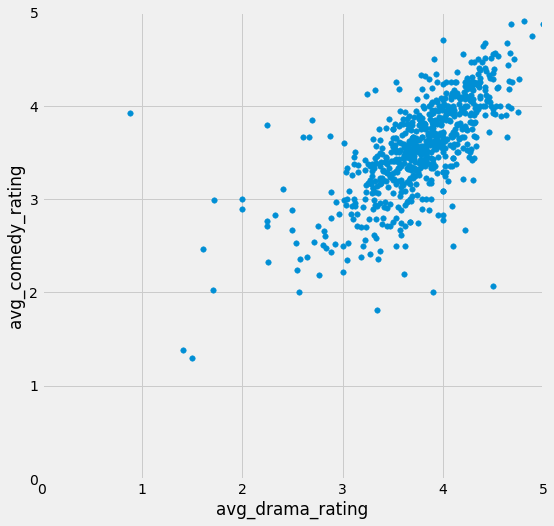

In [27]:
draw_scatterplot(x_data= genre_ratings['avg_drama_rating'], x_label= 'avg_drama_rating', y_data= genre_ratings['avg_comedy_rating'], y_label='avg_comedy_rating')

In [28]:
genre_ratings_bias = filter_out_bias_df(df= genre_ratings, col1= genre_colnames[0], col2= genre_colnames[1], score_limit_1= 3.5, score_limit_2= 2.5)

print(f'Bias data frame shape: {genre_ratings_bias.shape}')
genre_ratings_bias.head()

Bias data frame shape: (287, 2)


,avg_drama_rating,avg_comedy_rating
1,2.57,2.00
2,3.62,3.09
6,3.55,2.91
12,2.76,2.71
14,2.00,3.00


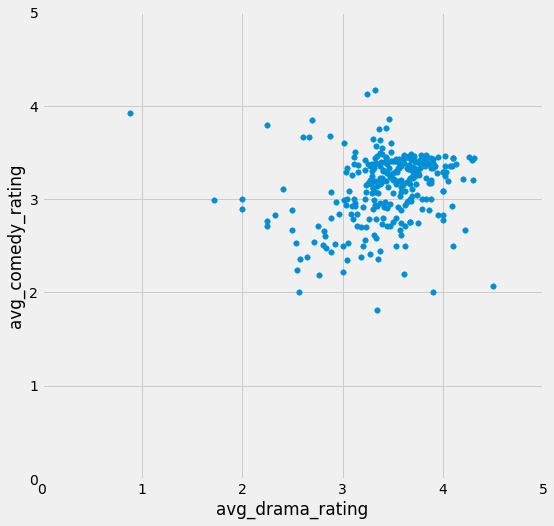

In [29]:
draw_scatterplot(x_data= genre_ratings_bias['avg_drama_rating'], x_label= 'avg_drama_rating', y_data= genre_ratings_bias['avg_comedy_rating'], y_label='avg_comedy_rating')

In [30]:
## K Means
def draw_clusters(df, predictions, cmap='viridis'):
    '''
    Plot Kmeans clusters

    Parameters
    ----------
    df : pandas as np.array
        dataset or values array.
    predictions : numpy.ndarray
        KMeans(n_clusters).fi_predict.
    cmap : str, optional
        color of clusters. The default is 'viridis'.

    Returns
    -------
    None.

    '''
    n_cluster = len(set(predictions))
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(df.columns[0])
    ax.set_ylabel(df.columns[1])
    ax.set_title(f'{n_cluster} Clusters')
    clustered = pd.concat([df.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=clustered['group'], s=20, cmap=cmap)
    plt.show()
    return None

Full Data Customer


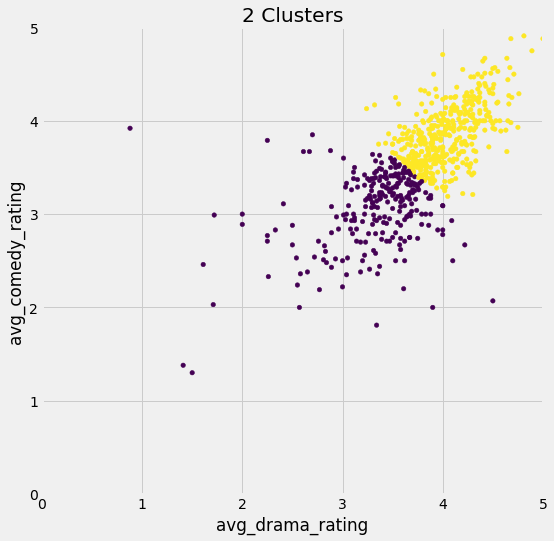

In [31]:
cluster_number = 2

df = genre_ratings
X = df.fillna(0).values
kmeans_1 = KMeans(n_clusters=cluster_number, random_state=0)
predictions = kmeans_1.fit_predict(X)
print('Full Data Customer')
draw_clusters(df, predictions)

This is not ver useful because the clusters are the people that like both and the people that like neither

### Subset the Data
We are only concerned with the middle portion where the main activity is happening

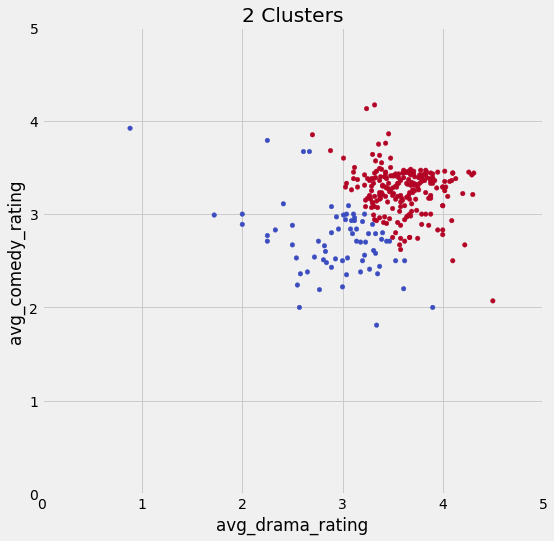

In [32]:
# 2 Clusters
cluster_number = 2
df = genre_ratings_bias
X = df.values
kmeans_1 = KMeans(n_clusters=cluster_number, random_state=0)
predictions = kmeans_1.fit_predict(X)
draw_clusters(df, predictions, cmap= 'coolwarm')

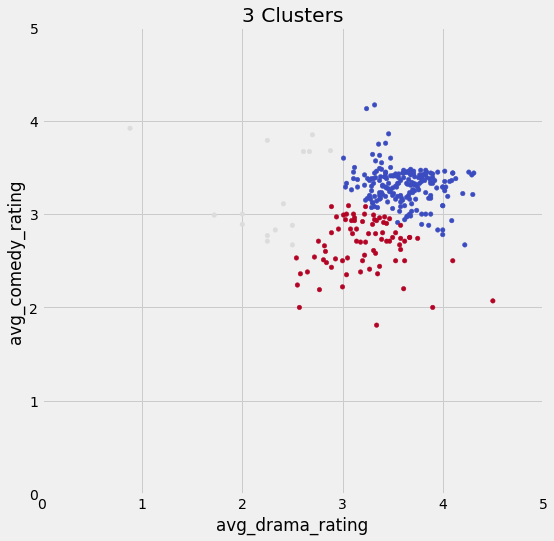

In [33]:
# 3 Clusters
cluster_number = 3
df = genre_ratings_bias
X = df.values
kmeans_1 = KMeans(n_clusters=cluster_number, random_state=0)
predictions = kmeans_1.fit_predict(X)
draw_clusters(df, predictions, cmap= 'coolwarm')

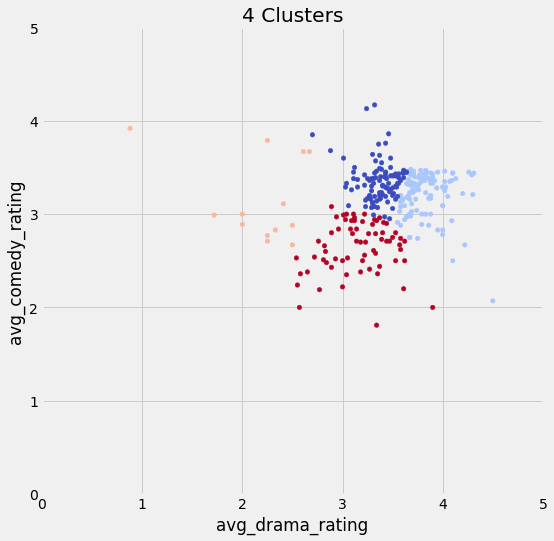

In [34]:
# 4 Clusters
cluster_number = 4
df = genre_ratings_bias
X = df.values
kmeans_1 = KMeans(n_clusters=cluster_number, random_state=0)
predictions = kmeans_1.fit_predict(X)
draw_clusters(df, predictions, cmap= 'coolwarm')

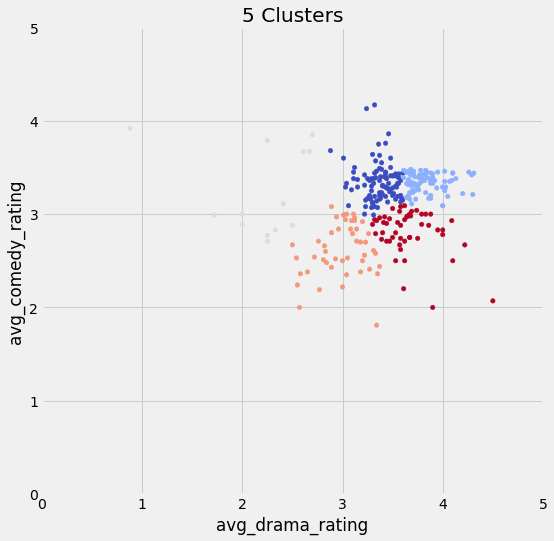

In [35]:
# 5 Clusters
cluster_number = 5
df = genre_ratings_bias
X = df.values
kmeans_1 = KMeans(n_clusters=cluster_number, random_state=0)
predictions = kmeans_1.fit_predict(X)
draw_clusters(df, predictions, cmap= 'coolwarm')

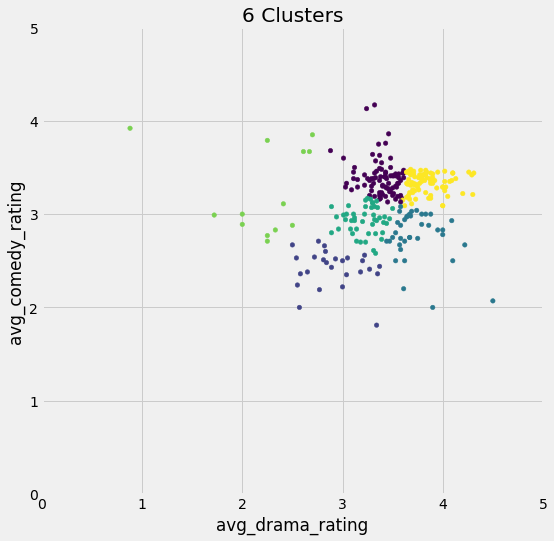

In [36]:
cluster_number = 6
df = genre_ratings_bias
X = df.values
kmeans_1 = KMeans(n_clusters=cluster_number, random_state=0)
predictions = kmeans_1.fit_predict(X)
draw_clusters(df, predictions)

Adding more clusters makes the pairs smaller and data has more similarities. We can make recomendations to user by genre, because there are similarities amongs

## Cluster by Movie 

In [37]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
ratings_title.head()

,userId,movieId,rating,timestamp,title
0,1,31,2.5,1260759144,Dangerous Minds (1995)
1,7,31,3.0,851868750,Dangerous Minds (1995)
2,31,31,4.0,1273541953,Dangerous Minds (1995)
3,32,31,4.0,834828440,Dangerous Minds (1995)
4,36,31,3.0,847057202,Dangerous Minds (1995)


In [41]:
# Create Data frame row: Users, col: Movies
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
user_movie_ratings.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This is a sparse data frame and will create a sparse matrix

In [42]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection



def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

In [43]:
n_movies = 20
n_users = 20
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (20, 20)


title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),Star Wars: Episode V - The Empire Strikes Back (1980),Braveheart (1995),Back to the Future (1985),Fargo (1996),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),American Beauty (1999),Independence Day (a.k.a. ID4) (1996),Star Wars: Episode VI - Return of the Jedi (1983),Aladdin (1992),"Fugitive, The (1993)"
267,5.0,5.0,3.5,5.0,5.0,4.5,4.5,5.0,5.0,5.0,5.0,4.5,5.0,3.5,5.0,3.0,3.0,4.0,4.5,4.0
441,5.0,4.5,4.5,5.0,5.0,4.5,4.5,4.0,4.5,4.0,4.5,4.5,4.0,4.0,4.5,4.0,3.5,4.5,4.5,4.5
29,5.0,5.0,5.0,4.0,4.0,4.0,3.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0
22,4.5,4.5,5.0,4.5,4.5,3.5,4.0,3.0,3.5,3.5,4.5,3.5,4.5,4.5,4.5,3.5,3.5,4.0,4.0,3.5
118,3.0,5.0,4.0,4.0,5.0,4.0,4.0,2.0,5.0,4.0,4.0,5.0,4.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0


In [44]:
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    '''
    Will build heatmap of array where each rating is a different color
    '''
    
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()
    return None

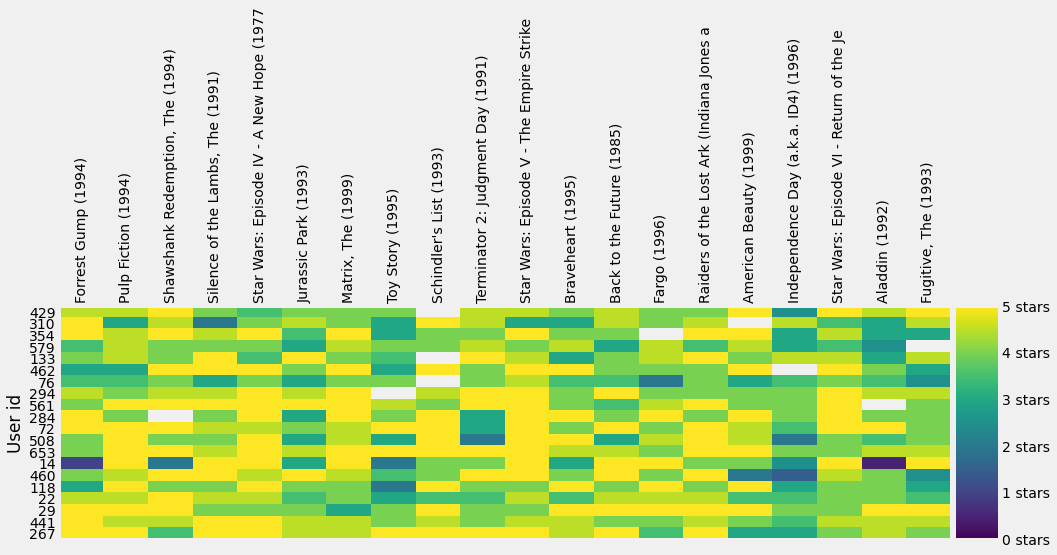

In [45]:
draw_movies_heatmap(most_rated_movies_users_selection)

In [46]:
movie_number = 1000

user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies = get_most_rated_movies(user_movie_ratings, movie_number)
print(f'Dataset shape: {most_rated_movies.shape}')
most_rated_movies.head()

Dataset shape: (671, 1000)


title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Insomnia (2002),What Lies Beneath (2000),Roman Holiday (1953),"Motorcycle Diaries, The (Diarios de motocicleta) (2004)",Sophie's Choice (1982),Dawn of the Dead (2004),Ocean's Thirteen (2007),Seabiscuit (2003),Easy Rider (1969),Lucky Number Slevin (2006)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,4.0,NaN,3.0,NaN,4.0,NaN,NaN,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,4.5,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,5.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Convert to Sparse Matrix

In [47]:
sparse_ratings = csr_matrix(most_rated_movies.fillna(0).values).toarray()
sparse_ratings

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [3. , 4. , 0. , ..., 0. , 0. , 0. ],
       [5. , 4.5, 5. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 5. , ..., 0. , 0. , 0. ],
       [5. , 4. , 5. , ..., 3.5, 0. , 0. ]])

## Cluster Sparse Data Frame 

In [48]:
cluster_number = 15
# 25 clusters
predictions = KMeans(n_clusters= cluster_number, algorithm='full').fit_predict(sparse_ratings)
clustered = pd.concat([most_rated_movies.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
clustered.head()


,index,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),...,What Lies Beneath (2000),Roman Holiday (1953),"Motorcycle Diaries, The (Diarios de motocicleta) (2004)",Sophie's Choice (1982),Dawn of the Dead (2004),Ocean's Thirteen (2007),Seabiscuit (2003),Easy Rider (1969),Lucky Number Slevin (2006),group
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,1,3.0,4.0,NaN,3.0,NaN,4.0,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,2,5.0,4.5,5.0,3.0,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,3,5.0,5.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


## Prediction

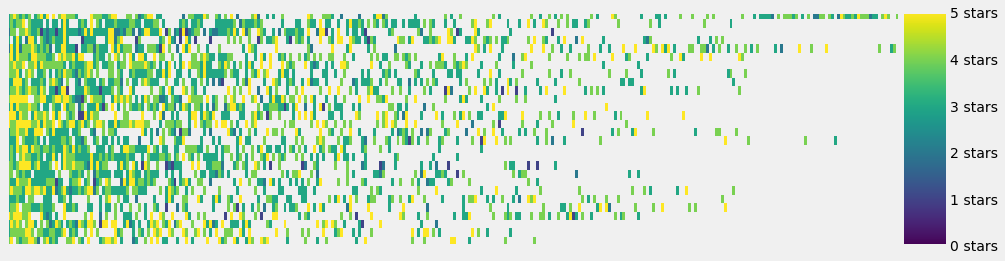

In [49]:
# Specific cluster
cluster_number = 3

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [50]:
cluster.fillna('').head()
cluster.head()

,Pretty Woman (1990),Forrest Gump (1994),Dances with Wolves (1990),"Silence of the Lambs, The (1991)",Jurassic Park (1993),"Fugitive, The (1993)",Terminator 2: Judgment Day (1991),Pulp Fiction (1994),Four Weddings and a Funeral (1994),Mrs. Doubtfire (1993),...,My Best Friend's Wedding (1997),Sleepy Hollow (1999),Falling Down (1993),Unforgiven (1992),Rush Hour (1998),Beavis and Butt-Head Do America (1996),Conspiracy Theory (1997),Highlander (1986),Star Trek VI: The Undiscovered Country (1991),Payback (1999)
20,3.0,4.0,5.0,4.0,3.0,4.0,3.0,4.0,NaN,3.0,...,2.0,3.0,3.0,NaN,4.0,5.0,4.0,NaN,NaN,4.0
21,3.0,4.0,3.0,4.0,4.0,5.0,NaN,4.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,4.0,4.0,NaN,4.0,4.0,5.0,4.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,NaN,3.0,5.0,3.0,NaN,2.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2.0,5.0,3.0,5.0,2.0,4.0,4.0,4.0,5.0,4.0,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,4.0,NaN


In [51]:
import random
random_col_idx = random.randint(0,len(cluster.columns))
movie_name = cluster.columns[random_col_idx]
#print(movie_name)
avg_movie_rating = cluster[movie_name].mean()
print(f'{movie_name} Average Rating: {round(avg_movie_rating, 3)}')


Sabrina (1995) Average Rating: 4.2


In [52]:
## Recommendation
cluster.mean().head(20)

Pretty Woman (1990)                   3.464286
Forrest Gump (1994)                   4.148148
Dances with Wolves (1990)             3.807692
Silence of the Lambs, The (1991)      4.576923
Jurassic Park (1993)                  3.923077
Fugitive, The (1993)                  4.120000
Terminator 2: Judgment Day (1991)     4.120000
Pulp Fiction (1994)                   4.280000
Four Weddings and a Funeral (1994)    3.833333
Mrs. Doubtfire (1993)                 3.791667
True Lies (1994)                      3.625000
Lion King, The (1994)                 3.791667
Ghost (1990)                          3.583333
Firm, The (1993)                      3.375000
Batman (1989)                         3.166667
Apollo 13 (1995)                      4.043478
Stargate (1994)                       3.045455
Sleepless in Seattle (1993)           3.590909
Aladdin (1992)                        3.545455
Shawshank Redemption, The (1994)      4.636364
dtype: float64

In [53]:
cluster.fillna('').head()

,Pretty Woman (1990),Forrest Gump (1994),Dances with Wolves (1990),"Silence of the Lambs, The (1991)",Jurassic Park (1993),"Fugitive, The (1993)",Terminator 2: Judgment Day (1991),Pulp Fiction (1994),Four Weddings and a Funeral (1994),Mrs. Doubtfire (1993),...,My Best Friend's Wedding (1997),Sleepy Hollow (1999),Falling Down (1993),Unforgiven (1992),Rush Hour (1998),Beavis and Butt-Head Do America (1996),Conspiracy Theory (1997),Highlander (1986),Star Trek VI: The Undiscovered Country (1991),Payback (1999)
20,3.0,4.0,5.0,4.0,3.0,4.0,3.0,4.0,,3.0,...,2.0,3.0,3.0,,4.0,5.0,4.0,,,4.0
21,3.0,4.0,3.0,4.0,4.0,5.0,,4.0,3.0,3.0,...,,,,,,,,,,
4,2.0,4.0,4.0,,4.0,4.0,5.0,4.0,3.0,3.0,...,,,,,,,,,,
3,3.0,,3.0,5.0,3.0,,2.0,5.0,5.0,3.0,...,,,,,,,,,,
13,2.0,5.0,3.0,5.0,2.0,4.0,4.0,4.0,5.0,4.0,...,,,,4.0,,,,3.0,4.0,


In [67]:
random_user = cluster.fillna('').sample(1).index[0]

# Get all this user's ratings
user_2_ratings  = cluster.loc[random_user, :]

# Total reviews 
total_reviews_by_user = len(user_movie_ratings.loc[random_user, :].dropna())
print(f'User {random_user} has {total_reviews_by_user} movie review')
print()
print('Users top ratings:')
display(user_movie_ratings.loc[random_user, :].dropna().sort_values(ascending = False).head())

print('Users ratings in cluster:')
display(user_2_ratings.head())


User 10 has 46 movie review

Users top ratings:


title
13th Warrior, The (1999)               5.0
Hairspray (1988)                       5.0
There's Something About Mary (1998)    5.0
Sweet Hereafter, The (1997)            5.0
Sling Blade (1996)                     5.0
Name: 10, dtype: float64

Users ratings in cluster:


Pretty Woman (1990)                 4.0
Forrest Gump (1994)                 5.0
Dances with Wolves (1990)           4.0
Silence of the Lambs, The (1991)    4.0
Jurassic Park (1993)                4.0
Name: 10, dtype: float64

In [68]:
# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
print("Movies in cluster not seen by user:")
user_2_unrated_movies.head()

Movies in cluster not seen by user:


Cliffhanger (1993)           NaN
In the Line of Fire (1993)   NaN
Crimson Tide (1995)          NaN
Crow, The (1994)             NaN
Dave (1993)                  NaN
Name: 10, dtype: float64

In [69]:
pick_from_top_movies = 20

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first
print('Movies Average Rating in Cluster not seen by user:')
avg_ratings.sort_values(ascending=False)[:pick_from_top_movies].head()

Movies Average Rating in Cluster not seen by user:


Double Jeopardy (1999)                                                         5.0
Beavis and Butt-Head Do America (1996)                                         5.0
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)      5.0
Deer Hunter, The (1978)                                                        5.0
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)    5.0
Name: 0, dtype: float64

In [70]:
recommendations_given = 4
list_of_recommended_movies = list(avg_ratings.sort_values(ascending=False)[:pick_from_top_movies].sample(recommendations_given).index)
print(f'The list of recommended movies for user {random_user} is: \n\n{list_of_recommended_movies}')

The list of recommended movies for user 10 is: 

['Platoon (1986)', 'Fish Called Wanda, A (1988)', 'Star Wars: Episode IV - A New Hope (1977)', 'Blade Runner (1982)']


## Recommender Function via K-Means
All this information is useful, but it needs to be in a singular function.  A function is created to input a user. The the function will cluster the data, find the user's groups and make reccomendations based on the group

In [83]:
def movie_recommender_k_means_cluster(user_movie_ratings, user_id= 143, cluster_number = 20):
    '''
    Finds recomendations for specific user based on number of clusters

    Parameters
    ----------
    user_movie_ratings : pandas
        data frame of users and movies row by col .
    user_id : int
        userid number for recommendatin.
    cluster_number : int, optional
        Number of clusters. The default is 20.

    Returns
    -------
    list_of_recommended_movies : list
        list of movies recommended.

    '''
    ## Variables
    user_idx = user_id -1
    pick_from_top_movies = 20
    recommendations_given = 4
    
    # Top movies and users for heat map
    n_users = 75
    n_movies = 300
    
    # Get csr matrix of data frame (speed)
    sparse_ratings = csr_matrix(user_movie_ratings.fillna(0).values).toarray()
    
    # Kmeans cluster
    predictions = KMeans(n_clusters= cluster_number, algorithm='full').fit_predict(sparse_ratings)
    clustered = pd.concat([user_movie_ratings.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    clustered = clustered.drop(['userId'], axis=1)
    user_group = clustered.iloc[user_idx, -1]
    
    try: 
        cluster = clustered[clustered.group == user_group].drop(['index', 'group'], axis=1)
    except KeyError: 
        cluster = clustered[clustered.group == user_group].drop(['group'], axis=1)
    
    cluster_heat = sort_by_rating_density(cluster, n_movies, n_users)
    #draw_movies_heatmap(cluster_heat, axis_labels=False)
    
    # Get all this user's ratings
    user_2_ratings  = cluster.loc[user_idx, :]
    print('Users ratings for movies in cluster:')
    print(user_2_ratings.sort_values(ascending = False).head())
    
    total_reviews_by_user = len(user_movie_ratings.loc[user_id, :].dropna())
    print(f'User {user_id} has {total_reviews_by_user} movie reviews')
    print()
    print('Users top ratings:')
    display(user_movie_ratings.loc[user_id, :].dropna().sort_values(ascending = False).head())

    # Which movies did they not rate? (We don't want to recommend movies they've already rated)
    user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
    movies_seen = list(user_2_ratings[user_2_ratings.notnull()].index)    
    # Find the movies they did not see in heatmap
    movies_unseen = []
    for heat_movie in cluster_heat.columns:
        if heat_movie not in movies_seen:
            movies_unseen.append(heat_movie)
    
    # Subset heatmap cluster for unseen moves
    user_2_unrated_movies = cluster_heat.loc[:, movies_unseen]

    # What are the ratings of these movies the user did not rate?
    avg_ratings = user_2_unrated_movies.mean().sort_values(ascending=False)  
    #avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
    # Let's sort by rating so the highest rated movies are presented first
    print()
    print('Movies Average Rating in Cluster not seen by user:')
    display(avg_ratings[:pick_from_top_movies].head() )   
    
    list_of_recommended_movies = list(avg_ratings.sort_values(ascending=False)[:pick_from_top_movies].sample(recommendations_given).index)
    print(f'The list of recommended movies for user {user_id} is: \n\n{list_of_recommended_movies}')
    return list_of_recommended_movies

In [84]:
ratings_title[ratings_title.loc[:, 'userId'] == 143].head()

,userId,movieId,rating,timestamp,title
1281,143,47,4.5,1149649707,Seven (a.k.a. Se7en) (1995)
3027,143,225,1.0,1149648213,Disclosure (1994)
3722,143,296,4.0,1149649318,Pulp Fiction (1994)
4551,143,356,5.0,1149649352,Forrest Gump (1994)
5307,143,370,1.5,1149648270,Naked Gun 33 1/3: The Final Insult (1994)


In [85]:
# User 143, 25 Clusters
start_time = time.time()
movie_recommender_k_means_cluster(user_movie_ratings, user_id= 143, cluster_number = 25)
print(f'Total Time to Run: {time.time() - start_time}')

Users ratings for movies in cluster:
Kill Bill: Vol. 2 (2004)      5.0
Gone with the Wind (1939)     5.0
Finding Neverland (2004)      5.0
Forrest Gump (1994)           5.0
Clockwork Orange, A (1971)    5.0
Name: 142, dtype: float64
User 143 has 77 movie reviews

Users top ratings:


title
Kill Bill: Vol. 2 (2004)      5.0
Gone with the Wind (1939)     5.0
Finding Neverland (2004)      5.0
Forrest Gump (1994)           5.0
Clockwork Orange, A (1971)    5.0
Name: 143, dtype: float64


Movies Average Rating in Cluster not seen by user:


Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)     4.875000
African Queen, The (1951)                         4.833333
Cinema Paradiso (Nuovo cinema Paradiso) (1989)    4.812500
Hoop Dreams (1994)                                4.750000
Bridge on the River Kwai, The (1957)              4.750000
dtype: float64

The list of recommended movies for user 143 is: 

['Rear Window (1954)', 'Wallace & Gromit: The Best of Aardman Animation (1996)', 'Boot, Das (Boat, The) (1981)', 'Léon: The Professional (a.k.a. The Professional) (Léon) (1994)']
Total Time to Run: 5.123049974441528


In [86]:
# User 143, 15 Clusters
start_time = time.time()
movie_recommender_k_means_cluster(user_movie_ratings, user_id= 143, cluster_number = 15)
print(f'Total Time to Run: {time.time() - start_time}')

Users ratings for movies in cluster:
Kill Bill: Vol. 2 (2004)      5.0
Gone with the Wind (1939)     5.0
Finding Neverland (2004)      5.0
Forrest Gump (1994)           5.0
Clockwork Orange, A (1971)    5.0
Name: 142, dtype: float64
User 143 has 77 movie reviews

Users top ratings:


title
Kill Bill: Vol. 2 (2004)      5.0
Gone with the Wind (1939)     5.0
Finding Neverland (2004)      5.0
Forrest Gump (1994)           5.0
Clockwork Orange, A (1971)    5.0
Name: 143, dtype: float64


Movies Average Rating in Cluster not seen by user:


Ratatouille (2007)                                5.000000
African Queen, The (1951)                         4.833333
Cinema Paradiso (Nuovo cinema Paradiso) (1989)    4.812500
Psycho (1960)                                     4.750000
Stand by Me (1986)                                4.636364
dtype: float64

The list of recommended movies for user 143 is: 

['Psycho (1960)', 'Third Man, The (1949)', 'Citizen Kane (1941)', 'Hoop Dreams (1994)']
Total Time to Run: 4.063762903213501
